In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pydub import AudioSegment
import time

import pyaudio
import wave

from pyannote.core import Annotation, Segment
from pyannote.audio.pipelines import VoiceActivityDetection

In [2]:
silence_detection_pipeline = VoiceActivityDetection(segmentation="pyannote/segmentation")
HYPER_PARAMETERS = {
  # onset/offset activation thresholds
  "onset": 0.5, "offset": 0.5,
  # remove speech regions shorter than that many seconds.
  "min_duration_on": 0.0,
  # fill non-speech regions shorter than that many seconds.
  "min_duration_off": 0.0
}
silence_detection_pipeline.instantiate(HYPER_PARAMETERS)

In [5]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
RECORD_SECONDS = 30
WAVE_OUTPUT_FILENAME = "voice.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

TIME_TO_CUT = 1.5

t0 = time.time()
t0_start_talk = time.time()
silence_th = 0
frames = []

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)
    if time.time()-t0 > 3:
        
        # print("Hola", time.time()-t0_start_talk)
        
        wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
        wf.setnchannels(CHANNELS)
        wf.setsampwidth(p.get_sample_size(FORMAT))
        wf.setframerate(RATE)
        wf.writeframes(b''.join(frames))
        wf.close()
        
        vad = silence_detection_pipeline(WAVE_OUTPUT_FILENAME)
        
        x = vad.get_timeline().segments_set_
        
        if len(x) > 0:
            last_time_talk = np.max([x_elt.end for x_elt in list(x)])
            cond_listen = (time.time() - t0_start_talk) > 5
            if time.time()-(last_time_talk+t0_start_talk) > TIME_TO_CUT and cond_listen:
                break
            else:
                silence_th += len(x) - 1
        
        t0 = time.time()

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


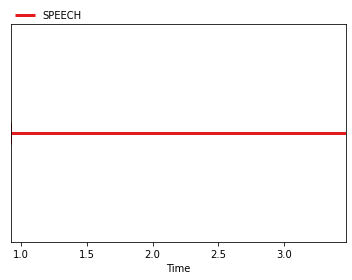

In [4]:
VAD = silence_detection_pipeline(WAVE_OUTPUT_FILENAME)
VAD